In [6]:
import pandas as pd
import os
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import random
from sklearn.preprocessing import normalize
import anndata as adata


In [7]:
colors_sns = sns.color_palette('colorblind')
colors_sns

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [31]:
def correlation_tile_plot(df_lfc, list_rvid_x, list_rvid_y, fig_size, cols, dict_rvid_to_name, list_subset=[], gene_names = True ):
    
    if gene_names:
        list_gene_names_x = [dict_rvid_to_name[rvid] for rvid in list_rvid_x]
        list_gene_names_y = [dict_rvid_to_name[rvid] for rvid in list_rvid_y]
    else:
        list_gene_names_x = list_rvid_x
        list_gene_names_y = list_rvid_y
    
    fig, axs = plt.subplots(len(list_rvid_x), len(list_rvid_y), figsize=fig_size)
    if max([len(list_rvid_x), len(list_rvid_y)]) >= 10:
        FontSize = 28
        size_param = 40
    elif max([len(list_rvid_x), len(list_rvid_y)]) <= 5:
        FontSize = 30
        size_param = 70
    else:
        FontSize = 30
        size_param = 70
    for i in range(len(list_rvid_x)):
        for j in range(len(list_rvid_y)):
            x_rvid = list_rvid_x[i]
            y_rvid = list_rvid_y[j] 

            x = df_lfc[df_lfc.Rv_ID==x_rvid].values[0][1:]
            y = df_lfc[df_lfc.Rv_ID==y_rvid].values[0][1:]

            axs[i,j].scatter(x, y, s = size_param, alpha = 0.75, edgecolors='k', linewidths=3)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            if i == 0:
                axs[i,j].set_title(list_gene_names_y[j], fontsize = FontSize)
            
            if j == 0:
                axs[i,j].set_ylabel(list_gene_names_x[i], fontsize = FontSize)
            
            if list_rvid_x == list_rvid_y:
                if x_rvid in list_subset or y_rvid in list_subset:
                    axs[i,j].set_facecolor('xkcd:lightblue')
                if x_rvid in list_subset and y_rvid in list_subset:
                    axs[i,j].set_facecolor(cols[-2])
                if i==j:
                    axs[i,j].set_facecolor(cols[-3])

In [9]:
path_data = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/'

In [11]:
fn_p = 'GLS_p_GE.npy'
fn_p_path = os.path.join(path_data, fn_p)
fn_genes = 'genes_GE.txt'
fn_genes_path = os.path.join(path_data, fn_genes)

genes = pd.read_csv( fn_genes_path, header=None, squeeze=True)
GLS_p = pd.DataFrame( np.load(fn_p_path), columns=genes, index=genes)


In [6]:
# Compute and save weights for ClusterONE
stacked_p = GLS_p.stack()
stacked_p = stacked_p[stacked_p.index.get_level_values(0) < stacked_p.index.get_level_values(1)]
# Bonferroni-corrected p-values: 
fdr = pd.Series(fdrcorrection(stacked_p)[1], index=stacked_p.index)

In [54]:
th = 0.001
fdr_th = fdr[fdr.values<=th].copy()

In [55]:
list_lead_gene = []
list_partner_gene = []
list_p_fdr = []
for rvid in genes.values.tolist():
    rvid_pair = [ind for ind in fdr_th.index if ind[0]==rvid or ind[1]==rvid]
    # how do I fetch the p-value for the interaction?
    p_fdr = fdr_th[rvid_pair].values.tolist()
    rvid_pair_sort = [(rv[0], rv[1]) if rv[0]==rvid else (rv[1], rv[0]) for rv in rvid_pair ]

    #lead_gene = [ rvid_pair_sort[i][0] if i==0 else '' for i in range(len(rvid_pair_sort))]
    lead_gene = [ rvid_pair_sort[i][0] for i in range(len(rvid_pair_sort))]
    partner_gene = [rvid[1] for rvid in rvid_pair_sort]

    list_lead_gene+=lead_gene
    list_partner_gene+=partner_gene
    list_p_fdr+=p_fdr

In [56]:
df_interact = pd.DataFrame()
df_interact['lead_gene'] = list_lead_gene
df_interact['partner_gene'] = list_partner_gene
df_interact['p_value_FDR'] = list_p_fdr


In [ ]:
fn_out = 'GLS_part_fdr.001.xlsx'
fn_out_path = os.path.join(path_data, fn_out)
df_interact.to_excel(fn_out_path, index=False)

## Writing everything to files and figures: 

### [PENDING]: what is the effect of normalization?

In [18]:
file_in = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/tb_adata_v2.h5ad'
a_GE_Tn = adata.read_h5ad(file_in)
print('mixed GE + TnSeq dataset size:', a_GE_Tn.shape)

ind_GE = a_GE_Tn.var[a_GE_Tn.var.data_type == 'expression'].index.tolist()
ind_GE = [int(i) for i in ind_GE]
mat_data = a_GE_Tn.X[:, ind_GE]

df_lfc = pd.DataFrame()
df_lfc['Rv_ID'] = genes
df_lfc = pd.concat([df_lfc, pd.DataFrame(mat_data)], axis=1)

mixed GE + TnSeq dataset size: (4016, 1226)


In [19]:
fn_in = 'GLS_partner_fdr.001.xlsx'
fn_in_path = os.path.join(path_data, fn_in)
df_interact = pd.read_excel(fn_in_path)
df_interact = df_interact[~df_interact.lead_gene.str.contains('nr')]

In [20]:
list_rvid_all = df_interact.lead_gene.unique().tolist()
list_rvid_filt = [rvid for rvid in list_rvid_all if int(rvid.split('Rv')[1][:4]) >= 2826]

In [11]:
num_rvids = 20
for rvid in list_rvid_filt:
    
    list_rvid = df_interact[df_interact.lead_gene == rvid].partner_gene.tolist()
    list_rvid+=[rvid]
    if len(list_rvid)>=num_rvids:
        list_rvid_sample = random.sample(list_rvid, num_rvids)
    else:
        list_rvid_sample = list_rvid.copy()
        
    correlation_tile_plot(df_lfc, list_rvid_sample, list_rvid_sample, (25,25), colors_sns)
    path = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/figs/GLS_GE/'
    fn_fig = rvid+'_interactions.png'
    plt.savefig(os.path.join(path, fn_fig), dpi = 250)
    plt.close()

## Exploring some of the correlations: 

In [29]:
fn = '/home/ajinich/Documents/repos/mtb_tn_db/data/annotations/uniprot_mtb_with_location.xlsx'
df_mtb_w_loc = pd.read_excel(fn)
df_mtb_w_loc = df_mtb_w_loc.fillna('')

re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_mtb_w_loc['Gene names']]
df_mtb_w_loc['Rv_ID'] = list_rvids

list_gene_names = [gn.split()[0] for gn in df_mtb_w_loc["Gene names"]]
df_mtb_w_loc['gene_names'] = list_gene_names

df_rvid_to_name = df_mtb_w_loc[['Rv_ID', 'gene_names']].copy() 

dict_rvid_to_name = {}
for index, row in df_rvid_to_name.iterrows():
    dict_rvid_to_name[row.Rv_ID] = row.gene_names

In [21]:
def get_NN12(rvid_query, df_interact):
    # first nearest neighbors: 
    df_NN1 = df_interact[(df_interact.lead_gene==rvid_query) | (df_interact.partner_gene==rvid_query)].copy()
    list_rvid_NN1 = list(set(df_NN1.lead_gene.tolist() + df_NN1.partner_gene.tolist()))
    list_rvid_NN1.sort()

    # second nearest neighbors: 
    df_NN2 = df_interact[ (df_interact.lead_gene.isin(list_rvid_NN1)) | (df_interact.partner_gene.isin(list_rvid_NN1))].copy()
    list_rvid_NN2 = list(set(df_NN2.lead_gene.tolist() + df_NN2.partner_gene.tolist()))
    list_rvid_NN2.sort()
    
    # third nearest neighbors: 
    df_NN3 = df_interact[ (df_interact.lead_gene.isin(list_rvid_NN2)) | (df_interact.partner_gene.isin(list_rvid_NN2))].copy()
    list_rvid_NN3 = list(set(df_NN3.lead_gene.tolist() + df_NN3.partner_gene.tolist()))
    list_rvid_NN3.sort()
    
    return list_rvid_NN1, list_rvid_NN2, list_rvid_NN3

In [50]:
rvid_query =  'Rv1314c' #'Rv1086'
# rvid_query = df_interact.sample()['lead_gene'].values[0]
list_rvid_NN1, list_rvid_NN2, list_rvid_NN3 = get_NN12(rvid_query, df_interact)
len(list_rvid_NN1), len(list_rvid_NN2), len(list_rvid_NN3)

(0, 0, 0)

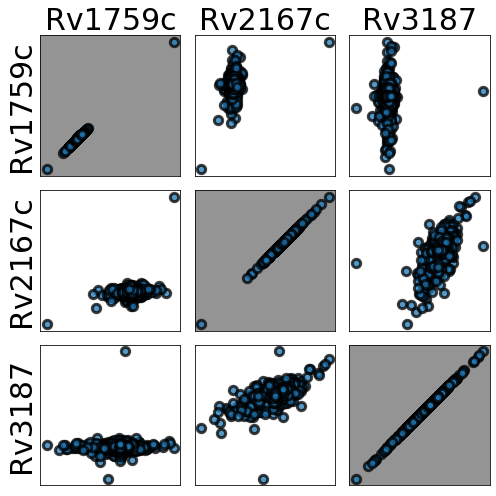

In [46]:
len_width = int(len(list_rvid_NN1)*2.5)
correlation_tile_plot(df_lfc, list_rvid_NN1, list_rvid_NN1, (len_width,len_width), colors_sns, dict_rvid_to_name, list_subset = [], gene_names = False)
plt.tight_layout()

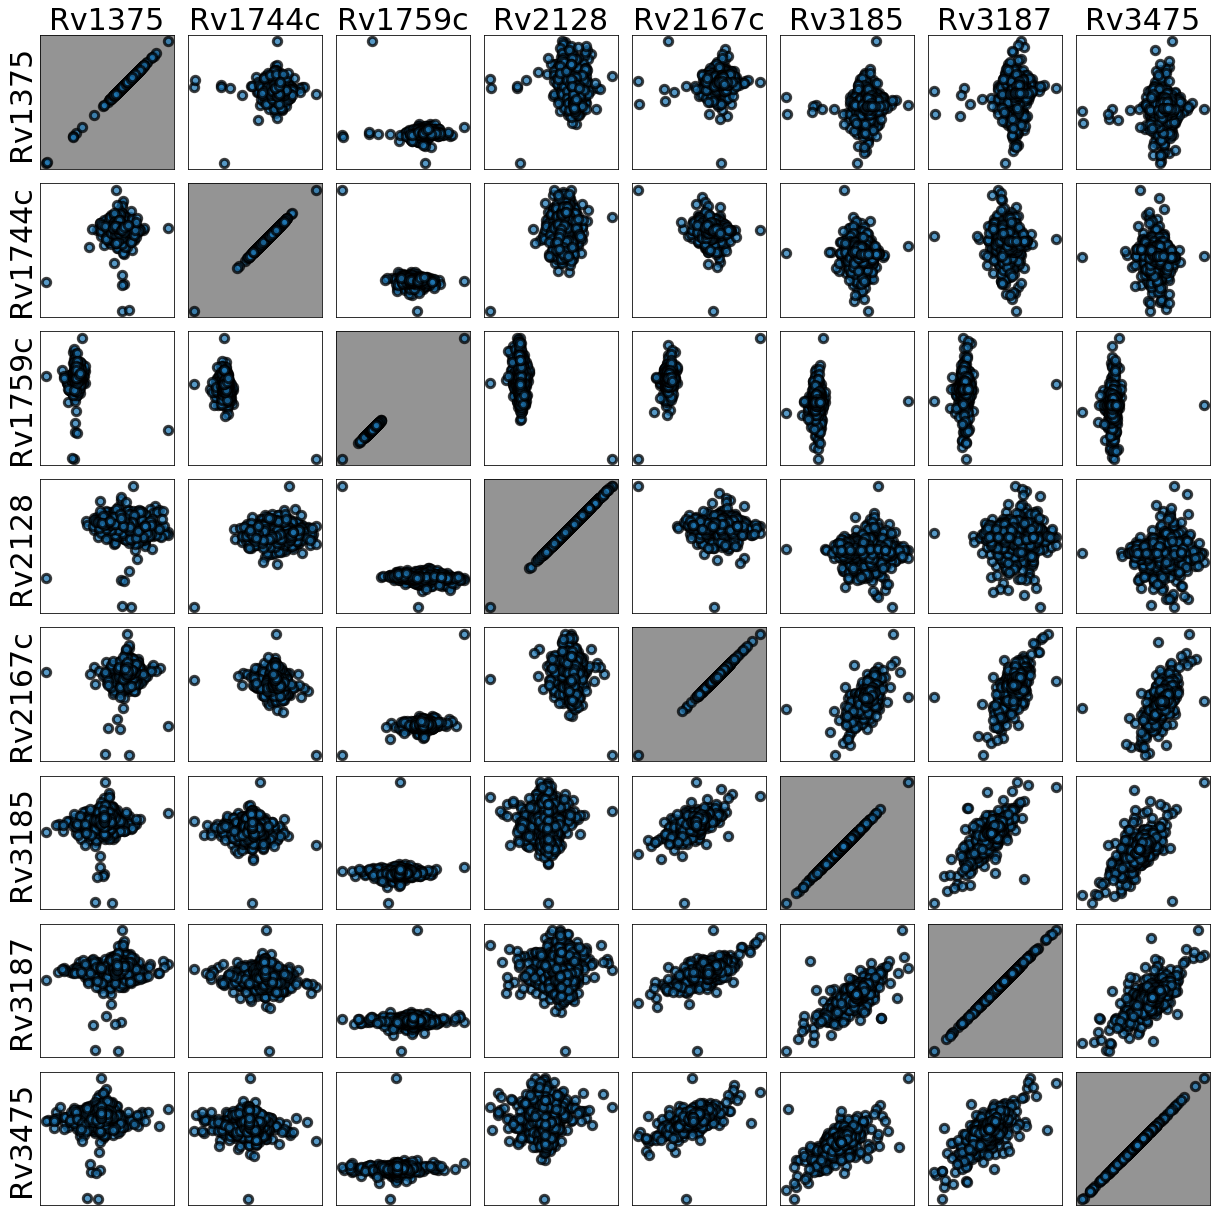

In [47]:
len_width = int(len(list_rvid_NN2)*2.2)
correlation_tile_plot(df_lfc, list_rvid_NN2, list_rvid_NN2, (len_width,len_width), colors_sns, dict_rvid_to_name, list_subset = ['Rv3044'], gene_names=False)
plt.tight_layout()

Random sets of genes: 

In [32]:
list_rvid_rand = df_lfc.Rv_ID.sample(10).tolist()

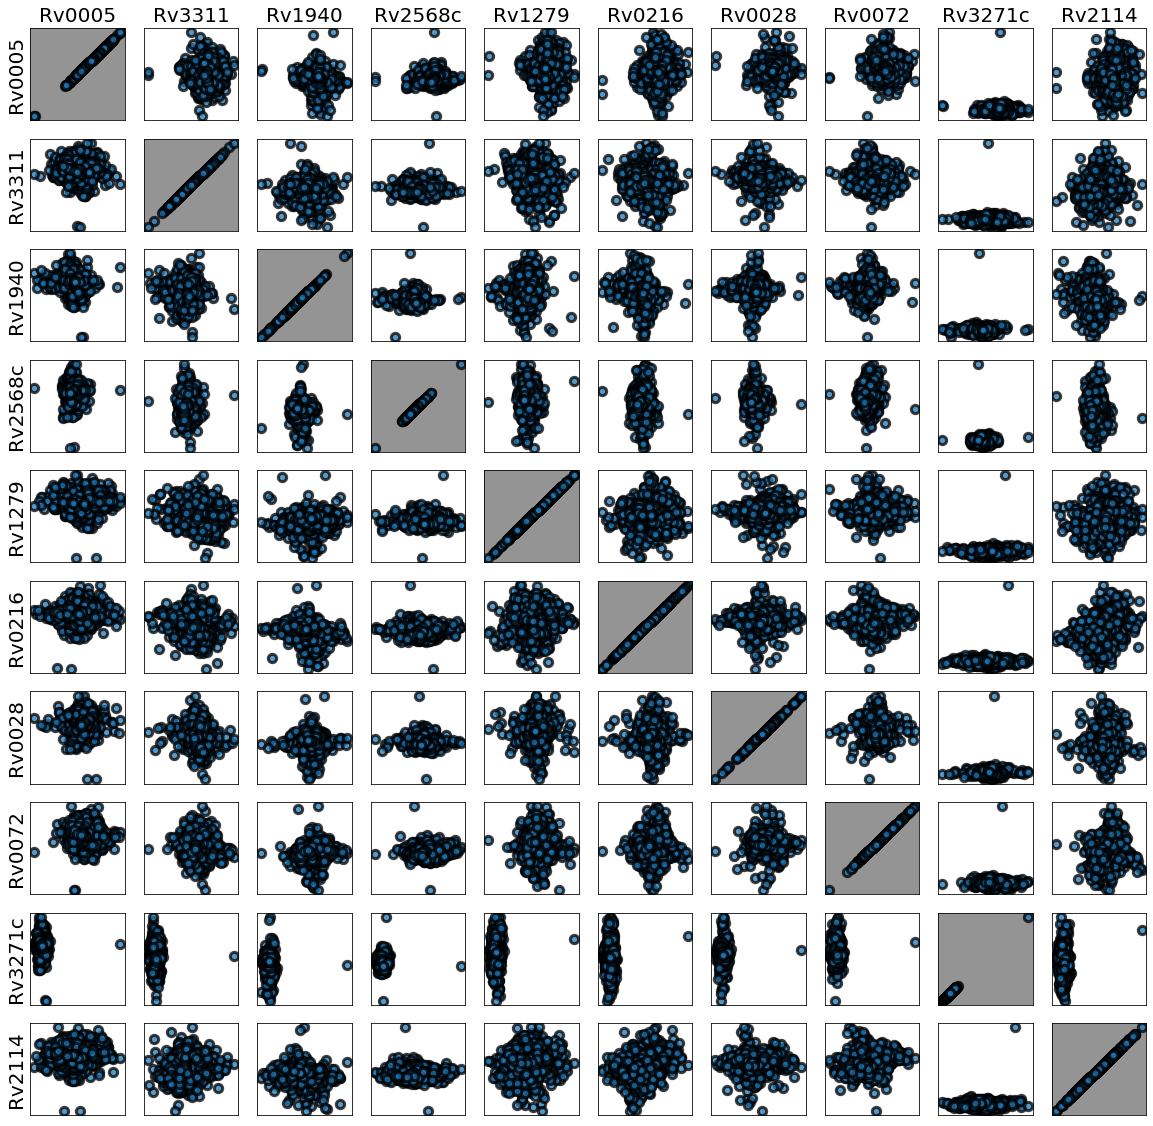

In [33]:
correlation_tile_plot(df_lfc, list_rvid_rand, list_rvid_rand, (20, 20), colors_sns)

From interactions below p-value threshold:

In [60]:
rvid = 'Rv3502c'
list_rvid = df_interact[df_interact.lead_gene==rvid].partner_gene.tolist() + [rvid]
list_rvid.sort()

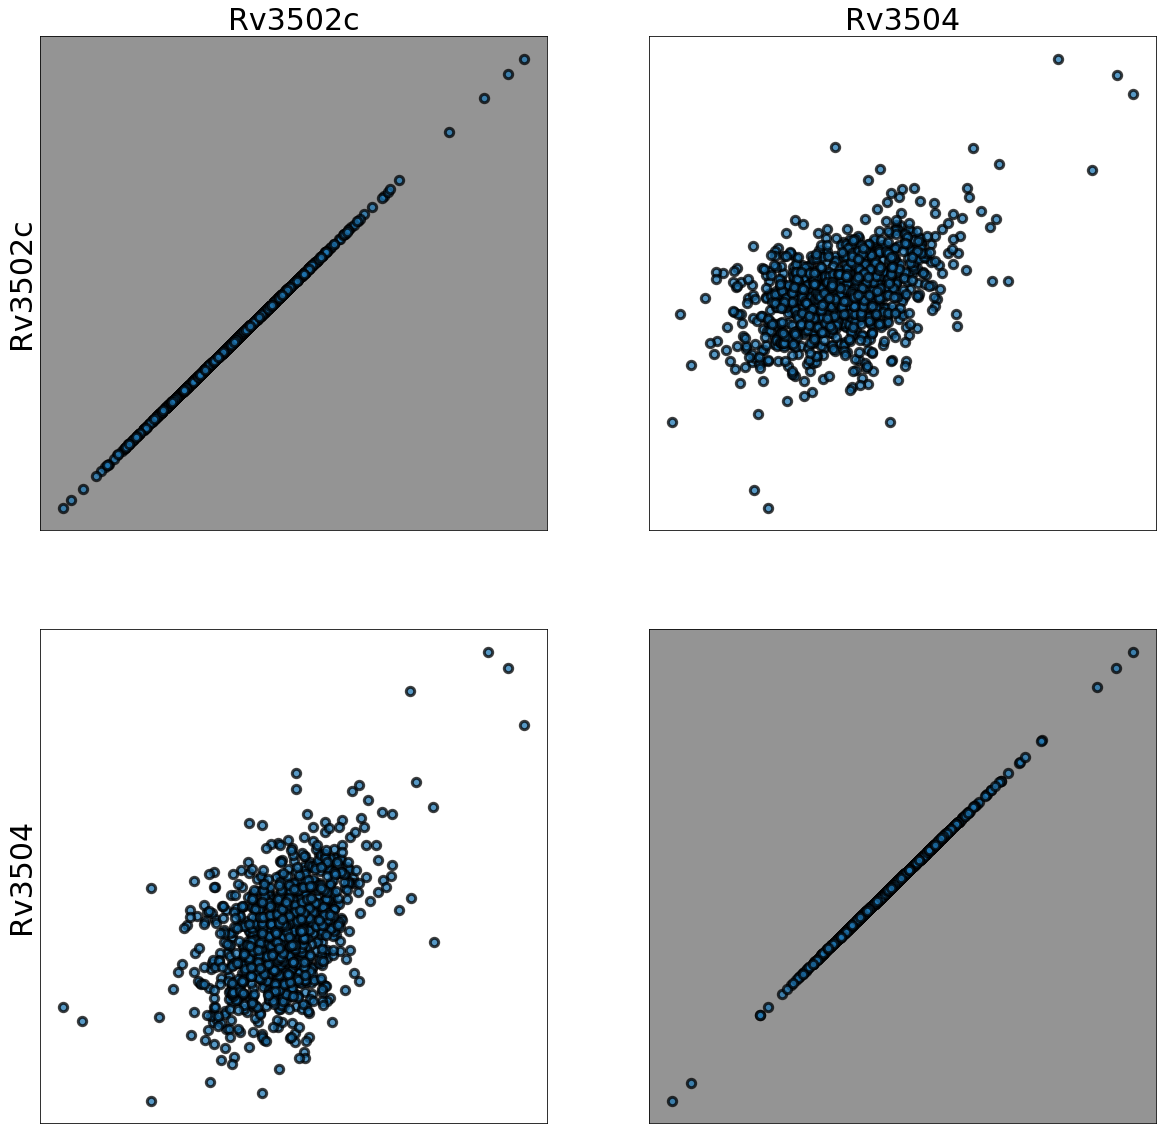

In [61]:
correlation_tile_plot(df_lfc, list_rvid, list_rvid, (20, 20), colors_sns)

In [63]:
df_interact.lead_gene.value_counts()

Rv2274A    42
Rv0724A    40
Rv0192A    37
Rv0236A    34
Rv1954A    34
           ..
Rv0795      1
Rv2250c     1
Rv2274c     1
Rv2279      1
Rv2007c     1
Name: lead_gene, Length: 1429, dtype: int64